# Tune GPT2 to generate controlled sentiment reviews
> Optimise GPT2 to produce IMDB movie reviews with controlled sentiment using a BERT sentiment classifier for rewards.

**WARNING:** We often experienced loss spikes in this examples which caused model training to fail or slow down. There is a [GitHub issue](https://github.com/lvwerra/trl/issues/101) to track the issue.

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-setup.png' width='600'>
<p style="text-align: center;"> <b>Figure:</b> Experiment setup to tune GPT2. The yellow arrows are outside the scope of this notebook, but the trained models are available through Hugging Face. </p>
</div>


The experiment setup is very similar to the positive sentiment notebook. However, in this notebook we fine-tune GPT2 (small) to generate **controlled** movie reviews based on the IMDB dataset. The model gets the target sentiment and 5 tokens from a real review and is tasked to produce continuations with the targeted sentiment. The reward for the continuations is calculated with the logits of a BERT sentiment classifier. That reward is then used for PPO training.

## Setup experiment

### Import dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
import wandb
import time
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt

tqdm.pandas()

from datasets import load_dataset

from transformers import AutoTokenizer, pipeline

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model

/home/leandro_huggingface_co/miniconda3/envs/trl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configuration

In [3]:
sentiment_pipe_kwargs = {"top_k": None, "function_to_apply": "none"}

config = PPOConfig(
    model_name="lvwerra/gpt2-imdb", steps=51200, learning_rate=1.41e-5, remove_unused_columns=False, log_with="wandb"
)

txt_in_len = 5
txt_out_len = 20
seed = 1

In [4]:
np.random.seed(seed)

You can see that we load a GPT2 model called `gpt2_imdb`. This model was additionally fine-tuned on the IMDB dataset for 1 epoch with the huggingface [script](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py) (no special settings). The other parameters are mostly taken from the original paper ["Fine-Tuning Language Models from Human Preferences"](
https://arxiv.org/pdf/1909.08593.pdf). This model as well as the BERT model is available in the Huggingface model zoo [here](https://huggingface.co/models). The following code should automatically download the models.

## Load data and models

### Load pre-trained GPT2 language models

We load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [5]:
gpt2_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
gpt2_model_ref = create_reference_model(gpt2_model)
gpt2_tokenizer = AutoTokenizer.from_pretrained(config.model_name)

gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

### Load IMDB dataset
The IMDB dataset contains 50k movie review annotated with "positive"/"negative" feedback indicating the sentiment.  We load the IMDB dataset into a DataFrame and filter for comments that are at least 500 characters long and take the first 1000 characters of each comment. The first filter we apply to avoid comments that are less than `txt_in_len` token long and the second to avoid tokenizing way more text than we actually need.

In [6]:
# create the dataset
#
dataset = load_dataset("imdb", split="train")
dataset = dataset.rename_columns({"text": "review", "label": "sentiment"})
# make sure the comments are are at least 500 and trim to 1000
dataset = dataset.filter(lambda x: len(x["review"]) > 500, batched=False)
dataset = dataset.map(lambda x: {"review": x["review"][:1000]}, batched=False)

dataset

Found cached dataset imdb (/home/leandro_huggingface_co/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached processed dataset at /home/leandro_huggingface_co/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-d314b4c14499bf03.arrow
Loading cached processed dataset at /home/leandro_huggingface_co/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-0d5fcb05c95b1186.arrow


Dataset({
    features: ['review', 'sentiment'],
    num_rows: 22578
})

### Tokenize IMDB reviews

We tokenize all IMDB in advance to avoid tokenizing twice. In the first step we encode the queries and slice the first `txt_in_len` tokens. In a second step we decode these tokens back to text for later display.

In [7]:
dataset = dataset.map(
    lambda x: {"input_ids": gpt2_tokenizer.encode(" " + x["review"], return_tensors="pt")[0, :txt_in_len]},
    batched=False,
)
dataset = dataset.map(lambda x: {"query": gpt2_tokenizer.decode(x["input_ids"])}, batched=False)
dataset = dataset[:20480]

from datasets import Dataset

dataset = Dataset.from_dict(dataset)
dataset.set_format("pytorch")

Loading cached processed dataset at /home/leandro_huggingface_co/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-383f6ebf0ae41ee4.arrow
Loading cached processed dataset at /home/leandro_huggingface_co/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f4875ad4fccbbc1f.arrow


In [8]:
dataset[3]["input_ids"]

tensor([ 770, 2646,  373, 2192, 7867])

In [9]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

In [10]:
ppo_trainer = PPOTrainer(config, gpt2_model, gpt2_model_ref, gpt2_tokenizer, dataset, data_collator=collator)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lvwerra. Use `wandb login --relogin` to force relogin


### Load BERT classifier
We load a BERT classifier fine-tuned on the IMDB dataset.

In [11]:
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  # to avoid a `pipeline` bug
else:
    device = ppo_trainer.accelerator.device
sentiment_pipe = pipeline("sentiment-analysis", "lvwerra/distilbert-imdb", device=device)

The model outputs are the logits for the negative and positive class. We will use the logits for positive class as a reward signal for the language model.

In [12]:
text = "this movie was really bad!!"
output = sentiment_pipe(text, **sentiment_pipe_kwargs)
output

[{'label': 'NEGATIVE', 'score': 2.3350484371185303},
 {'label': 'POSITIVE', 'score': -2.726576328277588}]

In [13]:
text = "this movie was really good!!"
output = sentiment_pipe(text, **sentiment_pipe_kwargs)
output

[{'label': 'POSITIVE', 'score': 2.557040214538574},
 {'label': 'NEGATIVE', 'score': -2.294790267944336}]

In [14]:
text = "this movie was a documentary"
output = sentiment_pipe(text, **sentiment_pipe_kwargs)
output

[{'label': 'POSITIVE', 'score': 0.8562759160995483},
 {'label': 'NEGATIVE', 'score': -0.7086048126220703}]

The resulting reward signal:

In [15]:
def extract_pipe_output(outputs):
    positive_logits = []
    for out in outputs:
        for element in out:
            if element["label"] == "POSITIVE":
                positive_logits.append(torch.tensor(element["score"]))
    return positive_logits

In [16]:
output[1]["score"]

-0.7086048126220703

### Control token dict
We will append the control token at the beginning of each query to signal the model what the target sentiment is. Each control sequence consists of three tokens:

In [17]:
ctrl_str = ["[negative]", "[neutral]", "[positive]"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # this should be handled by accelerate
ctrl_tokens = dict((s, gpt2_tokenizer.encode(s, return_tensors="pt").squeeze().to(device)) for s in ctrl_str)

In [18]:
ctrl_tokens

{'[negative]': tensor([   58, 31591,    60], device='cuda:0'),
 '[neutral]': tensor([   58, 29797,    60], device='cuda:0'),
 '[positive]': tensor([   58, 24561,    60], device='cuda:0')}

### Reward function

In [19]:
def pos_logit_to_reward(logit, task):
    """
    Take the positive sentiment logit and scale it for the task.
        task [negative]: reward = -logit
        task [neutral]: reward = -2*abs(logit)+4
        task [positive]: reward = logit
    """
    for i in range(len(logit)):
        if task[i] == "[negative]":
            logit[i] = -logit[i]
        elif task[i] == "[neutral]":
            logit[i] = -2 * torch.abs(logit[i]) + 4
        elif task[i] == "[positive]":
            pass
        else:
            raise ValueError("task has to be in [0, 1, 2]!")
    return logit

The following examples show the rewards for the cases where the classifier logit is 4, -4 and 0 for the three targets `['negative]`, `['neutral]` and `['positive']`. The scaling is not perfect as it differs between neutral and the other two classes. This is something to further investigate in the future. Ideally, one would use the logit output for each class individually, but since there is no dedicated class for neutral this is a workaround.

In [20]:
print(ctrl_str)

['[negative]', '[neutral]', '[positive]']


In [21]:
pos_logit_to_reward(torch.Tensor([4, 4, 4]), ctrl_str)

tensor([-4., -4.,  4.])

In [22]:
pos_logit_to_reward(torch.Tensor([-4, -4, -4]), ctrl_str)

tensor([ 4., -4., -4.])

In [23]:
pos_logit_to_reward(torch.Tensor([0, 0, 0]), ctrl_str)

tensor([-0., 4., 0.])

### Generation settings

In [24]:
generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": gpt2_tokenizer.eos_token_id,
    "max_new_tokens": txt_out_len,
    "eos_token_id": -1,
}

## Optimize model

**Steps**

The training loop consists of the following steps:
1. Get a batch of queries and create random controls
2. Get the query responses from the policy
3. Join query and responses and tokenize for BERT analysis
4. Get sentiments for query/responses from BERT
5. Optimize policy with PPO using the (query, response, reward) triplet
6. Log all the training statistics

**Training time**

This step takes **~2h** on a P6000 GPU with the above specified settings.

In [26]:
for epoch in range(2):
    for batch in tqdm(ppo_trainer.dataloader):
        (logs, game_data,) = (
            dict(),
            dict(),
        )

        #### prepend a random control token
        task_list = choices(ctrl_str, k=config.batch_size)
        game_data["query"] = [t + q for t, q in zip(task_list, batch["query"])]
        query_tensors = [torch.cat((ctrl_tokens[t], input_ids)) for t, input_ids in zip(task_list, batch["input_ids"])]

        #### get response from gpt2
        response_tensors = []
        for query in query_tensors:
            response = ppo_trainer.generate(query, **generation_kwargs)
            response_tensors.append(response.squeeze()[-txt_out_len:])
        game_data["response"] = [gpt2_tokenizer.decode(r.squeeze()) for r in response_tensors]

        #### sentiment analysis
        texts = [q + r for q, r in zip(batch["query"], game_data["response"])]
        logits = extract_pipe_output(sentiment_pipe(texts, **sentiment_pipe_kwargs))
        rewards = pos_logit_to_reward(logits, task_list)

        #### Run PPO training
        t = time.time()
        stats = ppo_trainer.step(query_tensors, response_tensors, rewards)

        for cs in ctrl_str:
            key = "env/reward_" + cs.strip("[]")
            stats[key] = np.mean([r.cpu().numpy() for r, t in zip(rewards, task_list) if t == cs])
        ppo_trainer.log_stats(stats, game_data, rewards)

  8%|▊         | 6/80 [12:44<2:37:54, 128.03s/it]/home/leandro_huggingface_co/miniconda3/envs/trl/lib/python3.9/site-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 91%|█████████▏| 73/80 [2:30:39<14:35, 125.03s/it]  

### Training progress
If you are tracking the training progress with Weights&Biases you should see a plot similar to the following:

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-stats.png' width='800'>
<p style="text-align: center;"> <b>Figure:</b> Reward mean and distribution evolution during training. </p>
</div>

One can observe how the model starts to generate more positive outputs after a few optimisation steps.

> Note: Investigating the KL-divergence will probably show that at this point the model has not converged to the target KL-divergence, yet. To get there would require longer training or starting with a higher inital coefficient.

## Model inspection

### Reward distribution
First, we can have a look at the reward distribution. Both the negative and positive rewards are clearly shifted to high rewards. The neutral rewards, however, are still centered around zero. There are a few possible explanations for this. There could be a bug in the code and the way the neutral rewards are calculated. Another problem could be that sentence sometimes start with a strong sentiment and it is hard for the model shift the sentiment towards neutral.

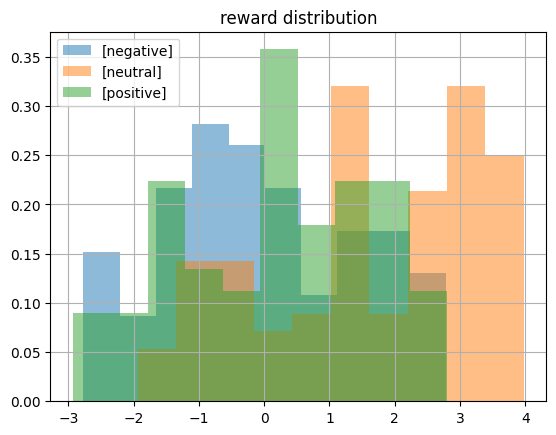

In [ ]:
for ctrl_s in ctrl_str:
    plt.hist(
        [r for r, t in zip(logs["env/reward_dist"], task_list) if t == ctrl_s], density=True, alpha=0.5, label=ctrl_s
    )
plt.legend(loc="best")
plt.title("reward distribution")
plt.grid(True)
plt.show()

## Save model
Finally, we save the model to disk for later usage.

In [ ]:
gpt2_model.save_pretrained("gpt2-imdb-ctrl")
gpt2_tokenizer.save_pretrained("gpt2-imdb-ctrl")